In [37]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
os.chdir("C:\\Users\\nxg05733\\RADIal")
from DBReader.DBReader import SyncReader
import pandas as pd

In [38]:
# Open the dataset
db = SyncReader("E:\\RADIal\\RECORD@2020-11-21_11.54.31",master='camera',tolerance=20000)

-------------------------------------------------------------------------
- Sensors available:
-     camera
-     can
-     gps
-     radar_ch0
-     radar_ch1
-     radar_ch2
-     radar_ch3
-     scala
-
- You might use function "setSensorFilters" to select sensors you want to read!
-------------------------------------------------------------------------
Total tolerance errors:  19.08150933261716 %


In [39]:
# Load the camera calibration parameters
calib = np.load('DBReader\examples\camera_calib.npy',allow_pickle=True).item()

In [78]:
# Retrieve one sample
data = db.GetSensorData(800)
image = data['camera']['data']

True

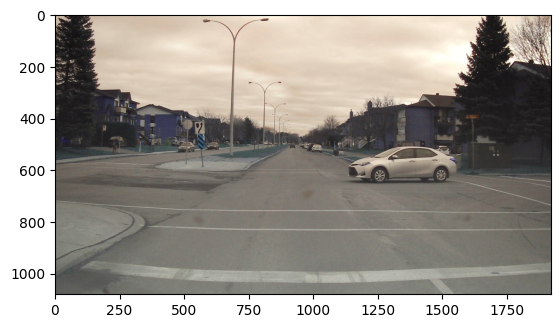

In [116]:
plt.imshow(image)
# save the image
cv2.imwrite("C:\\Users\\nxg05733\\Dense Lidar\\self-supervised-depth-completion\\scene.png", image)

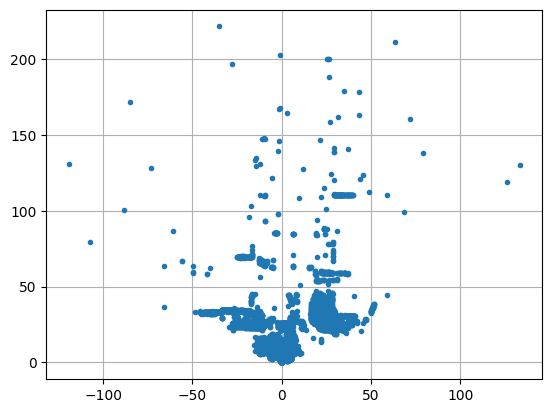

In [82]:
# Get the laser point cloud
pts = data['scala']['data']
plt.plot(pts[:,1],pts[:,0],'.')

plt.grid()

In [83]:
print('Number of points:',pts.shape[0])
print('Parameters per point:',pts.shape[1])

Number of points: 12448
Parameters per point: 11


In [84]:
# There are 11 parameters per point described sctructured as follow:
# [X, Y, Z, intensity, radialDistance, elevation_Angle, azimuth_angle, layer_index]

# Here is the trick, the Laser Scanner has 2 mirrors, one even and one odd. 
# There is a slight elevation angle difference between the 2 mirrors, so we have to compensate that angle

In [85]:
def ConpensateLayerAngle(pcl,index,sensor_height):
    
    offset=0
    if(index%2==0):
        offset = np.deg2rad(.6)

    x = pcl[:,4] * np.cos(pcl[:,5]+offset) * np.cos(pcl[:,6])
    y = pcl[:,4] * np.cos(pcl[:,5]+offset) * np.sin(pcl[:,6])
    z = pcl[:,4] * np.sin(pcl[:,5]+offset) + sensor_height
    
    pcl[:,0] = x
    pcl[:,1] = y
    pcl[:,2] = z
    
    return pcl

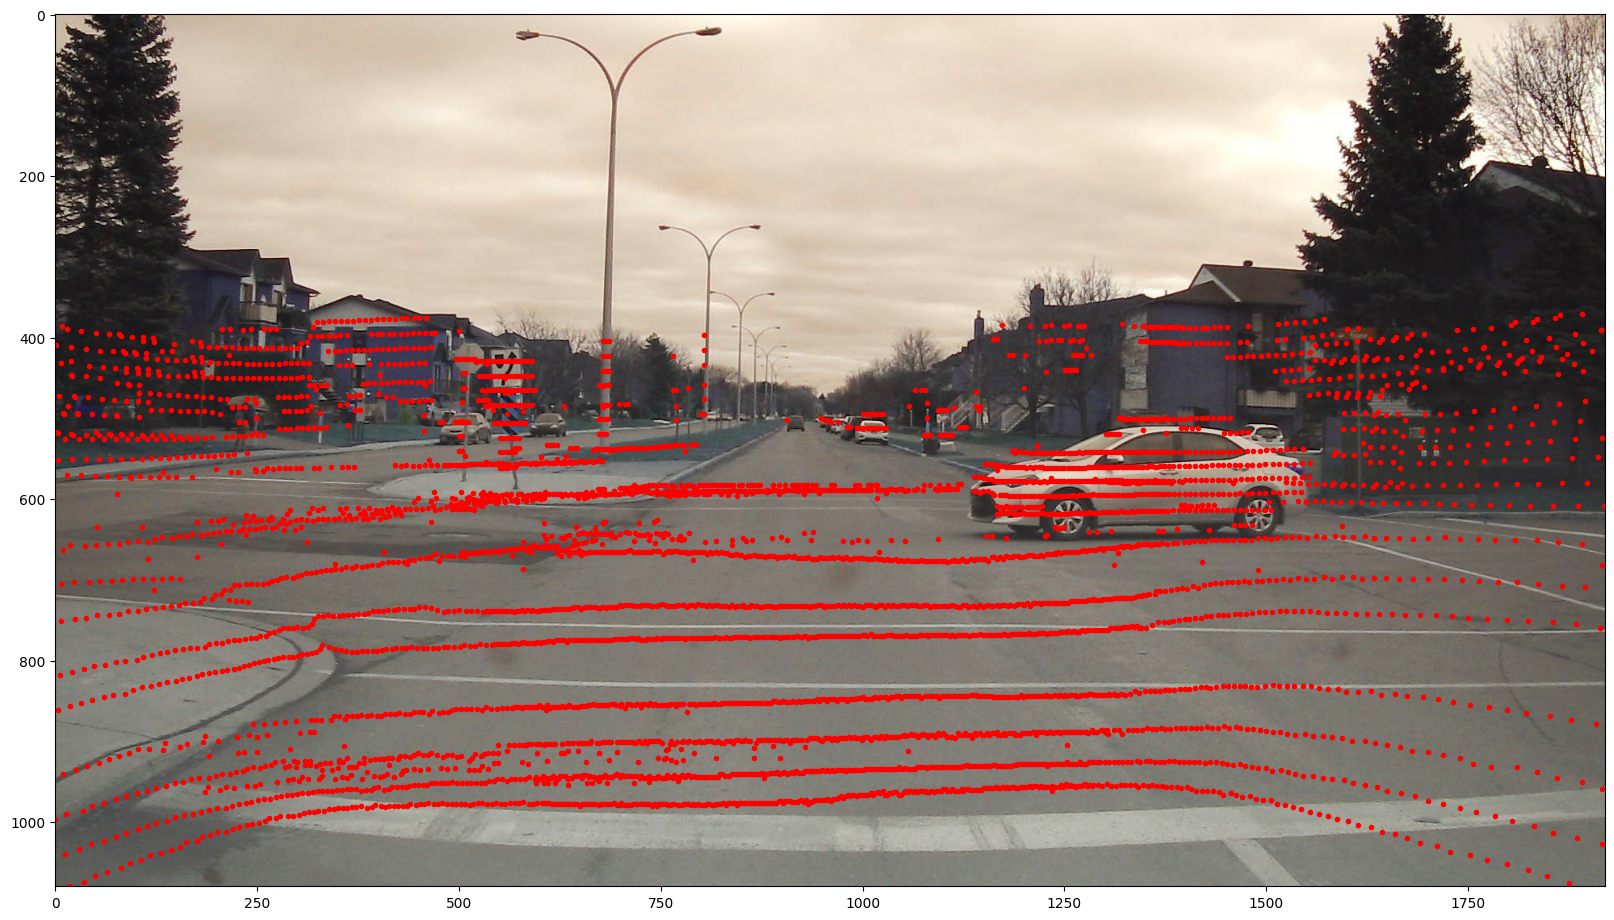

In [86]:
# Now, we can project 3D points into the camera space

all_pts = ConpensateLayerAngle(pts,data['scala']['sample_number'],0.42)
pts = all_pts[:,:3]
pts[:,[0, 1, 2]] = pts[:,[1, 0,2]] # Swap the order
pts[:,0]*=-1 # Left is positive

imgpts, _ = cv2.projectPoints(np.array(pts), 
                              calib['extrinsic']['rotation_vector'], 
                              calib['extrinsic']['translation_vector'],
                              calib['intrinsic']['camera_matrix'],
                              calib['intrinsic']['distortion_coefficients'])

imgpts=imgpts.squeeze(1).astype('int')

# Keep only points inside the image size
idx = np.where( (imgpts[:,0]>=0) & (imgpts[:,0]<image.shape[1]) & (imgpts[:,1]>=0) & (imgpts[:,1]<image.shape[0]))[0]

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.plot(imgpts[idx,0],imgpts[idx,1],'r.')

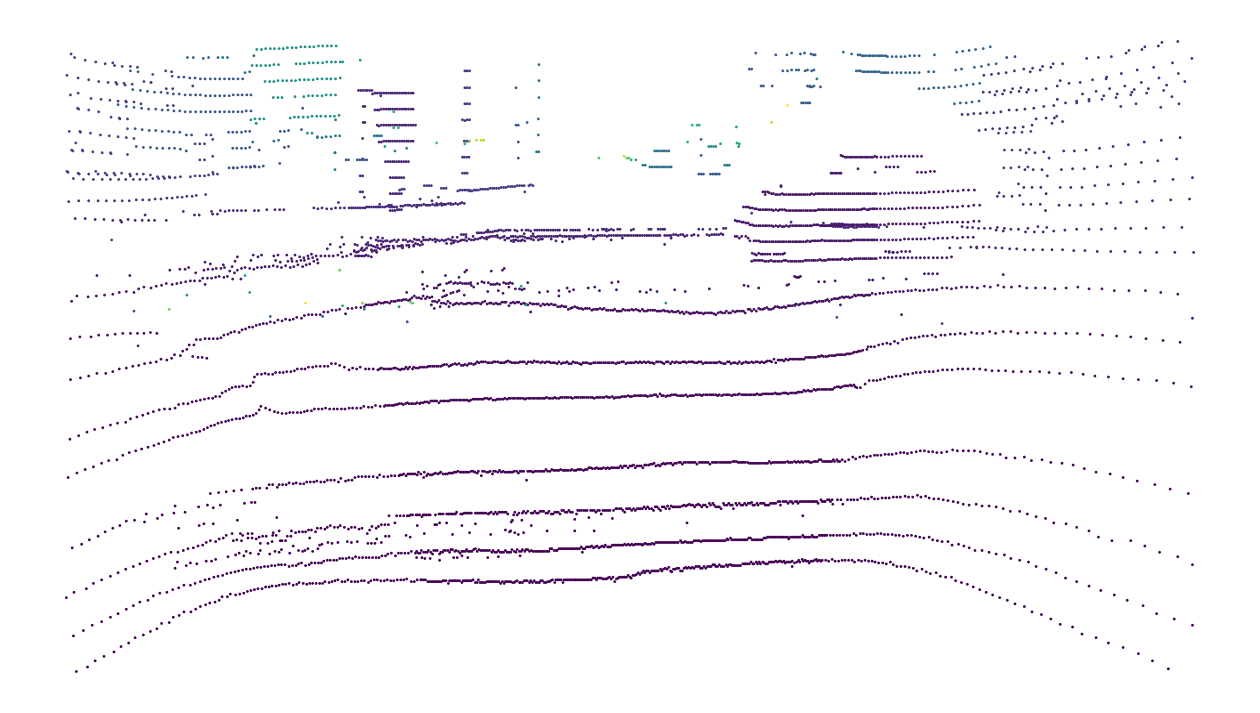

In [87]:
plt.figure(figsize=(16,9))
#plt.imshow(image)
plt.scatter(imgpts[idx,0],imgpts[idx,1], c = all_pts[idx,4], cmap = 'viridis',s=)
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()
# save the image


In [90]:
lidar_data = pd.DataFrame(all_pts, columns = ['X', 'Y', 'Z', 'intensity', 'radialDistance', 'elevation_Angle', 'azimuth_angle', 'layer_index', 'X1', 'Y1', 'Z1'])
lidar_data.radialDistance.max()

224.3699951171875

In [93]:
lidar_data['modif_radialDistance'] = lidar_data.radialDistance.apply(lambda x: x * 150/225)

In [107]:
lidar_data.describe()

,X,Y,Z,intensity,radialDistance,elevation_Angle,azimuth_angle,layer_index,X1,Y1,Z1,modif_radialDistance
count,12448.000000,12448.000000,12448.000000,12448.000000,12448.000000,12448.000000,12448.000000,12448.0,12448.0,12448.0,12448.0,12448.000000
mean,-0.961485,14.338723,0.991072,1.204245,16.964481,-0.004204,2.944684,0.0,0.0,0.0,0.0,11.309654
std,13.421429,19.518336,1.552487,1.006797,21.967245,0.051792,2.631362,0.0,0.0,0.0,0.0,14.644830
min,-133.217851,0.000000,-15.592600,0.040000,0.000000,-0.082886,0.000434,0.0,0.0,0.0,0.0,0.000000
25%,-2.983811,1.284700,0.226821,0.440000,3.040000,-0.051356,0.510997,0.0,0.0,0.0,0.0,2.026667
50%,-0.004073,5.863047,0.420000,1.000000,7.450000,-0.006597,1.056507,0.0,0.0,0.0,0.0,4.966667
75%,2.489982,24.547907,0.968795,1.760000,28.420000,0.038162,5.736051,0.0,0.0,0.0,0.0,18.946667
max,119.450766,221.372606,11.364275,14.040000,224.369995,0.082886,6.283095,0.0,0.0,0.0,0.0,149.579997


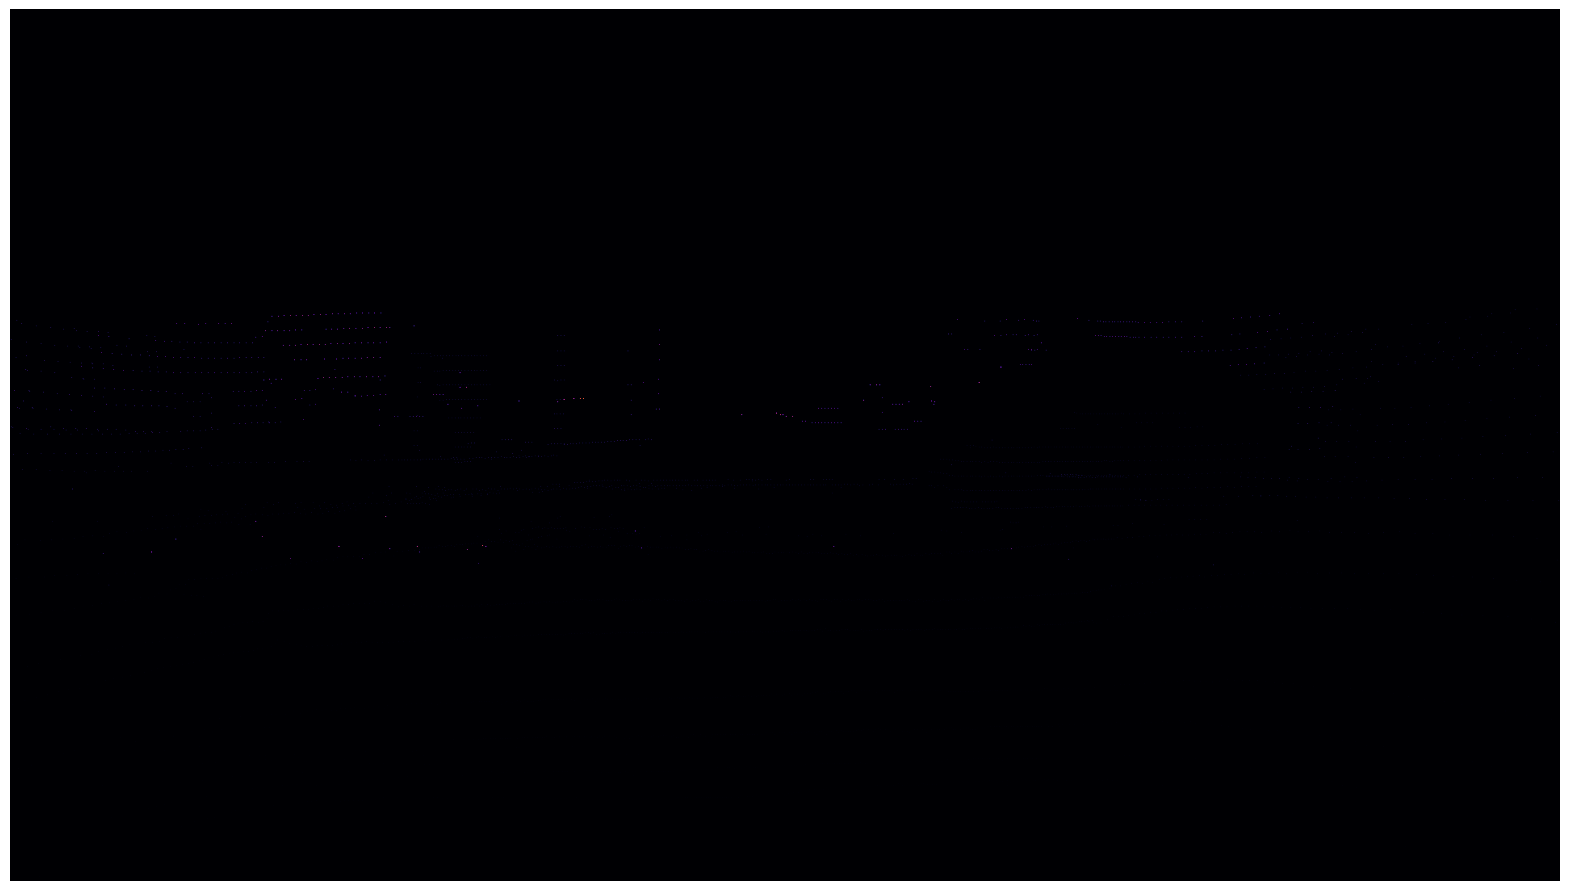

In [117]:
dummy_image = np.full((image.shape[0],image.shape[1]),0)
plt.figure(figsize=(20,20))
# replace dummy_image[imgpts[idx,0]][imgpts[idx,1]] with all_pts[idx,4]
for i in range(len(idx)):
    dummy_image[imgpts[idx[i],1],imgpts[idx[i],0]] =lidar_data.iloc[idx[i]].modif_radialDistance
    #plt.plot(imgpts[idx[i],0],imgpts[idx[i],1],'r.')
# set dummy_image > 100 to 1
plt.axis('off')
plt.imshow(dummy_image, cmap='inferno')
np.save('C:\\Users\\nxg05733\\Dense Lidar\\self-supervised-depth-completion\\lidar_data.npy',dummy_image)

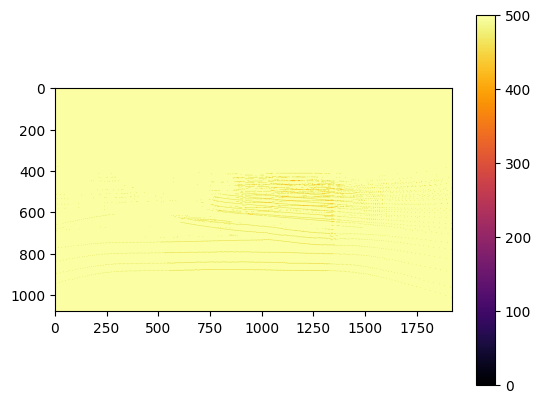

In [108]:
plt.imshow(dummy_image, cmap='inferno')
plt.colorbar()

In [105]:
dummy_image.max(),dummy_image.min()

(4.519999980926514, 0.0)